# Evaluación de resultados

En este notebook se muestran técnicas para la evaluación de los resultados de una predicción con un algoritmo de Machine Learning

## DataSet

### Abstract

NSL-KDD is a data set suggested to solve some of the inherent problems of the KDD'99 data set which are mentioned in [1]. Although, this new version of the KDD data set still suffers from some of the problems discussed by McHugh [2] and may not be a perfect representative of existing real networks, because of the lack of public data sets for network-based IDSs, we believe it still can be applied as an effective benchmark data set to help researchers compare different intrusion detection methods. Furthermore, the number of records in the NSL-KDD train and test sets are reasonable. This advantage makes it affordable to run the experiments on the complete set without the need to randomly select a small portion. Consequently, evaluation results of different research work will be consistent and comparable.

### Data Files

* <span style="color:green"> **KDDTrain+.ARFF** - The full NSL-KDD train set with binary labels in ARFF format </span>

* KDDTrain+.TXT - The full NSL-KDD train set including attack-type labels and difficulty level in CSV format

* KDDTrain+_20Percent.ARFF - A 20% subset of the KDDTrain+.arff file

* KDDTrain+_20Percent.TXT - A 20% subset of the KDDTrain+.txt file

* KDDTest+.ARFF - The full NSL-KDD test set with binary labels in ARFF format

* KDDTest+.TXT - The full NSL-KDD test set including attack-type labels and difficulty level in CSV format

* KDDTest-21.ARFF - A subset of the KDDTest+.arff file which does not include records with difficulty level of 21 out of 21

* KDDTest-21.TXT - A subset of the KDDTest+.txt file which does not include records with difficulty level of 21 out of 21

### Descargar los ficheros

https://www.unb.ca/cic/datasets/nsl.html

### Referencias adicionales sobre el DataSet

_References: [1] M. Tavallaee, E. Bagheri, W. Lu, and A. Ghorbani, “A Detailed Analysis of the KDD CUP 99 Data Set,” Submitted to Second IEEE Symposium on Computational Intelligence for Security and Defense Applications (CISDA), 2009._

## Imports

In [1]:
import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier

## Funciones Auxiliares

In [2]:
def load_kdd_dataset(data_path):
    """Lectura del conjunto de datos NSL-KDD."""
    with open(data_path, 'r') as train_set:
        dataset = arff.load(train_set)
    attributes = [attr[0] for attr in dataset["attributes"]]
    return pd.DataFrame(dataset["data"], columns=attributes)

In [3]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [4]:
# Construcción de un Pipeline para atributos númericos

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')),('rbs_scaler', RobustScaler()),])

In [5]:
# Transformador para codificar unicamente las columnas categoricas y devolver un DataFrame

class CustomerOneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__ (self):
        self._oh = OneHotEncoder(sparse_output = False)
        self._columns = None
    def fit (self, X, y = None):
        X_cat = X.select_dtypes(include = ['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform (self, X, y = None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include = ['object'])
        X_num = X_copy.select_dtypes(exclude = ['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, columns = self._columns, index = X_copy.index)
        X_copy.drop(list(X_cat), axis = 1, inplace = True)
        return X_copy.join(X_cat_oh)

In [6]:
# Transformador que prepara todo el DataSet llamado pipeline y transformadores personalizados

class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__ (self):
        self._full_pipeline = None
        self._columns = None
    def fit (self, X, y = None):
        num_attribs = list(X.select_dtypes(exclude = ['object']))
        cat_attribs = list(X.select_dtypes(include = ['object']))
        self._full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs), ('cat', CustomerOneHotEncoding(), cat_attribs),])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform (self, X, y = None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, columns = self._columns, index = X_copy.index)

## Lectura del DataSet

In [7]:
df = load_kdd_dataset("ALERT/datasets/datasets/NSL-KDD/KDDTrain+.arff")
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,19.0,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
6,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,9.0,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
7,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,15.0,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
8,0.0,tcp,remote_job,S0,0.0,0.0,0,0.0,0.0,0.0,...,23.0,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
9,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,13.0,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


## Divisón del DataSet

In [8]:
train_set, val_set, test_set = train_val_test_split(df, stratify = 'protocol_type')

In [9]:
print('Longitud del Training Set', len(train_set))
print('Longitud del Validation', len(val_set))
print('Longitud del test Set', len(test_set))

Longitud del Training Set 75583
Longitud del Validation 25195
Longitud del test Set 25195


Para cada uno de los subconjuntos, se separan las etiquetas de las características de entrada 

In [10]:
# Conjunto de datos general

X_df = df.drop('class', axis = 1)
y_df = df['class'].copy()

In [11]:
# Conjunto de detos de entrenamiento

X_train = train_set.drop('class', axis = 1)
y_train = train_set['class'].copy()

In [12]:
# Conjunto de validación

X_val = val_set.drop('class', axis = 1)
y_val = val_set['class'].copy()

In [13]:
# Conjunto de pruebas

X_test = test_set.drop('class', axis = 1)
y_test = test_set['class'].copy()

## Preparción del DataSet

In [14]:
# Instanciar el transformador personalizado

data_preparer = DataFramePreparer()

In [15]:
# Relaizar el fit con el DataSet general para que adquiera todos los datos posibles
data_preparer.fit(X_df)

DataFramePreparer()

In [16]:
X_train_prep = data_preparer.transform(X_train)
X_train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
113467,0.0,tcp,http,SF,407.0,53508.0,0,0.0,0.0,0.0,...,9.0,255.0,1.00,0.00,0.11,0.03,0.0,0.0,0.0,0.0
31899,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,4.0,0.02,0.05,0.00,0.00,1.0,1.0,0.0,0.0
108116,0.0,tcp,http,SF,304.0,636.0,0,0.0,0.0,0.0,...,39.0,255.0,1.00,0.00,0.03,0.06,0.0,0.0,0.0,0.0
89913,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,15.0,0.06,0.07,0.00,0.00,1.0,1.0,0.0,0.0
106319,0.0,icmp,eco_i,SF,8.0,0.0,0,0.0,0.0,0.0,...,2.0,7.0,1.00,0.00,1.00,0.57,0.0,0.0,0.0,0.0


In [17]:
X_train_prep.head(5)

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
113467,0.0,1.315217,103.697674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
31899,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
108116,0.0,0.942029,1.232558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
89913,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
106319,0.0,-0.130435,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [18]:
# Transformar el subconjunto de datos de validación

X_val_prep = data_preparer.transform(X_val)

## Entrenar el algoritmo de Regresión Logística

La instancia de un algoritmo de Machine Learning utiliza Scikitlearn que utiliza los métodos expuestos por el API de Scikitlearn tal y como se ha presentado en Notebooks anteriores.

In [19]:
# Entrenar el algoritmo basado en regresión logística

from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression(max_iter = 5000)
clf_logistic.fit(X_train_prep, y_train)


/home/terrazas/anaconda3/envs/Simulacion/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


## Predicción de nuevos ejemplos

Relizamos una predicción con el modelo generado anteriormente tras el entrenamiento del algoritmo de Regresión Logística. Se utiliza el subconjunto de validación.

### 1. Matiz de Confusión

In [20]:
from sklearn.metrics import confusion_matrix

y_pred = clf_logistic.predict(X_val_prep)

confusion_matrix(y_val, y_pred)

array([[11305,   464],
       [  246, 13180]])

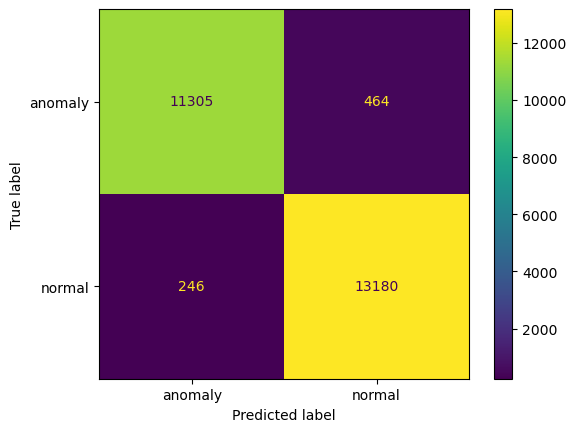

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf_logistic, X_val_prep, y_val, values_format = '3g')

### 2. Metricas derivadas de la matriz de confusión

#### Presición

In [22]:
from sklearn.metrics import precision_score

print('Precisión: ', precision_score(y_val, y_pred, pos_label = 'anomaly'))

Precisión:  0.9787031425850575


#### Recall

In [23]:
from sklearn.metrics import recall_score

print('Recall: ', recall_score(y_val, y_pred, pos_label = 'anomaly'))

Recall:  0.9605743903475231


#### F1 Score

In [24]:
from sklearn.metrics import f1_score

print('F1 score: ', f1_score(y_val, y_pred, pos_label = 'anomaly'))

F1 score:  0.9695540308747856


#### Curvas ROC y PR

##### Curva ROC

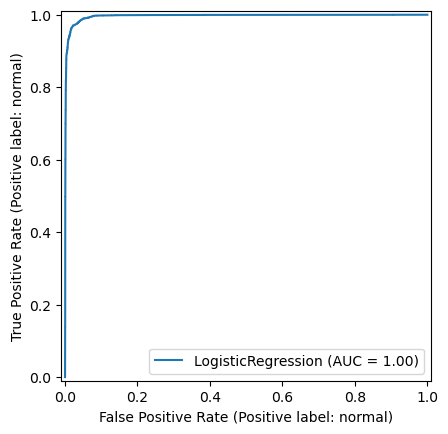

In [25]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf_logistic, X_val_prep, y_val)

##### Curva PR

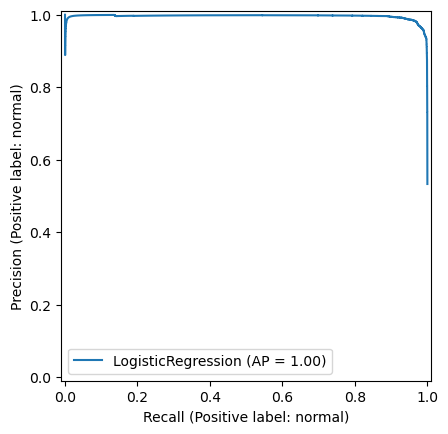

In [26]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf_logistic, X_val_prep, y_val)

### Evaluación del Modelo con el DataSet de Pruebas

In [27]:
# transoformar el subconjunto de datos de validación

X_test_prep = data_preparer.transform(X_test)
y_pred = clf_logistic.predict(X_test_prep)

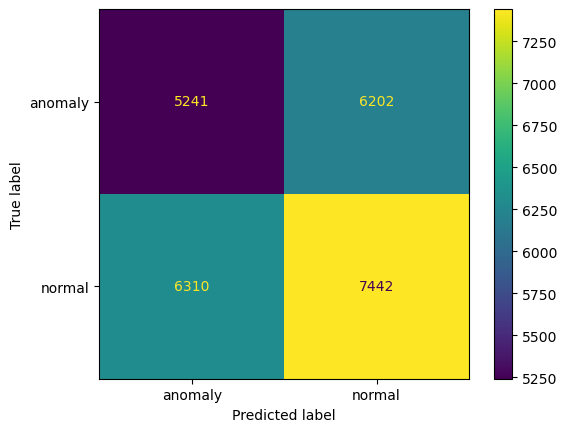

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf_logistic, X_val_prep, y_pred, values_format = '3g')

In [29]:
from sklearn.metrics import f1_score

print('F1 Score: ', f1_score(y_test, y_pred, pos_label = 'anomaly'))

F1 Score:  0.9688341001823075
